### Introduction

The present jupyter notebook demonstrates a machine learning approach for time series forecasting. In this experiment, we perform cross validation using Support Vector Regression. A series of input features are used using 2 lags. Further exploration around the improvement of the input features should be performed.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import r2_score, make_scorer
from sklearn.metrics import mean_absolute_error

# Load data
df = pd.read_csv("../Data/Appliances Energy Usage Prediction/energydata_complete.csv")

# Compute Lags
lagflag = True

df.head()

# Convert date column in the appropriate format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
# Extract the day of the week as a feature
df['day'] = pd.to_datetime(df['date']).dt.dayofweek

# Extract hour of the day
df['hour'] = pd.to_datetime(df['date']).dt.hour

df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'day', 'hour'],
      dtype='object')

In [2]:
df.shape

(19735, 31)

## Selection of Features

Correlation patterns between the selected features their lags and the target variable are explored

In [3]:
# Define the features and target variables
target = ["Appliances"]
features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2','day','hour'
           ]

# Define Train Test Split Ratio
train_split = 0.8
test_split = 0.2

# Obtain the master dataset
master_df = df[["date"] + target + features].copy()
master_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,day,hour
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,0,17
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,0,17
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,0,17
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,0,17
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,0,17


In [4]:
# Compute the lags of each and every variable
newFeatures = []
num_lags = int(2)
if lagflag is True:
    for i in target:
        for k in range(1,num_lags+1):
            # Create lags
            master_df["{}_{}".format(str(i), str(k))] = master_df[i].shift(k)
            newFeatures.append("{}_{}".format(str(i), str(k)))
else:
    newFeatures = features

features = newFeatures + features
master_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,day,hour,Appliances_1,Appliances_2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,92.0,7.000000,63.000000,5.3,13.275433,13.275433,0,17,NaN,NaN
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,92.0,6.666667,59.166667,5.2,18.606195,18.606195,0,17,60.0,NaN
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,0,17,60.0,60.0
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,92.0,6.000000,51.500000,5.0,45.410389,45.410389,0,17,50.0,60.0
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,92.0,5.666667,47.666667,4.9,10.084097,10.084097,0,17,50.0,50.0


In [5]:
# Drop Missing Values
master_df = master_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
master_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,day,hour,Appliances_1,Appliances_2
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,0,17,60.0,60.0
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,92.0,6.000000,51.500000,5.0,45.410389,45.410389,0,17,50.0,60.0
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,92.0,5.666667,47.666667,4.9,10.084097,10.084097,0,17,50.0,50.0
5,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,92.0,5.333333,43.833333,4.8,44.919484,44.919484,0,17,60.0,50.0
6,2016-01-11 18:00:00,60,50,19.89,45.766667,19.2,44.500000,19.79,44.900000,18.890000,...,92.0,5.000000,40.000000,4.7,47.233763,47.233763,0,18,50.0,60.0


### Splitting the Dataset into Train and Test Set

In [6]:
# Split dataset into train/ test set
train_records = int(np.round(train_split * master_df.shape[0]))
test_records = int(master_df.shape[0]-train_records)

X_train = master_df[:train_records][features].copy()
y_train = master_df[:train_records][target].copy()

X_test = master_df[-test_records:][features].copy()
y_test = master_df[-test_records:][target].copy()

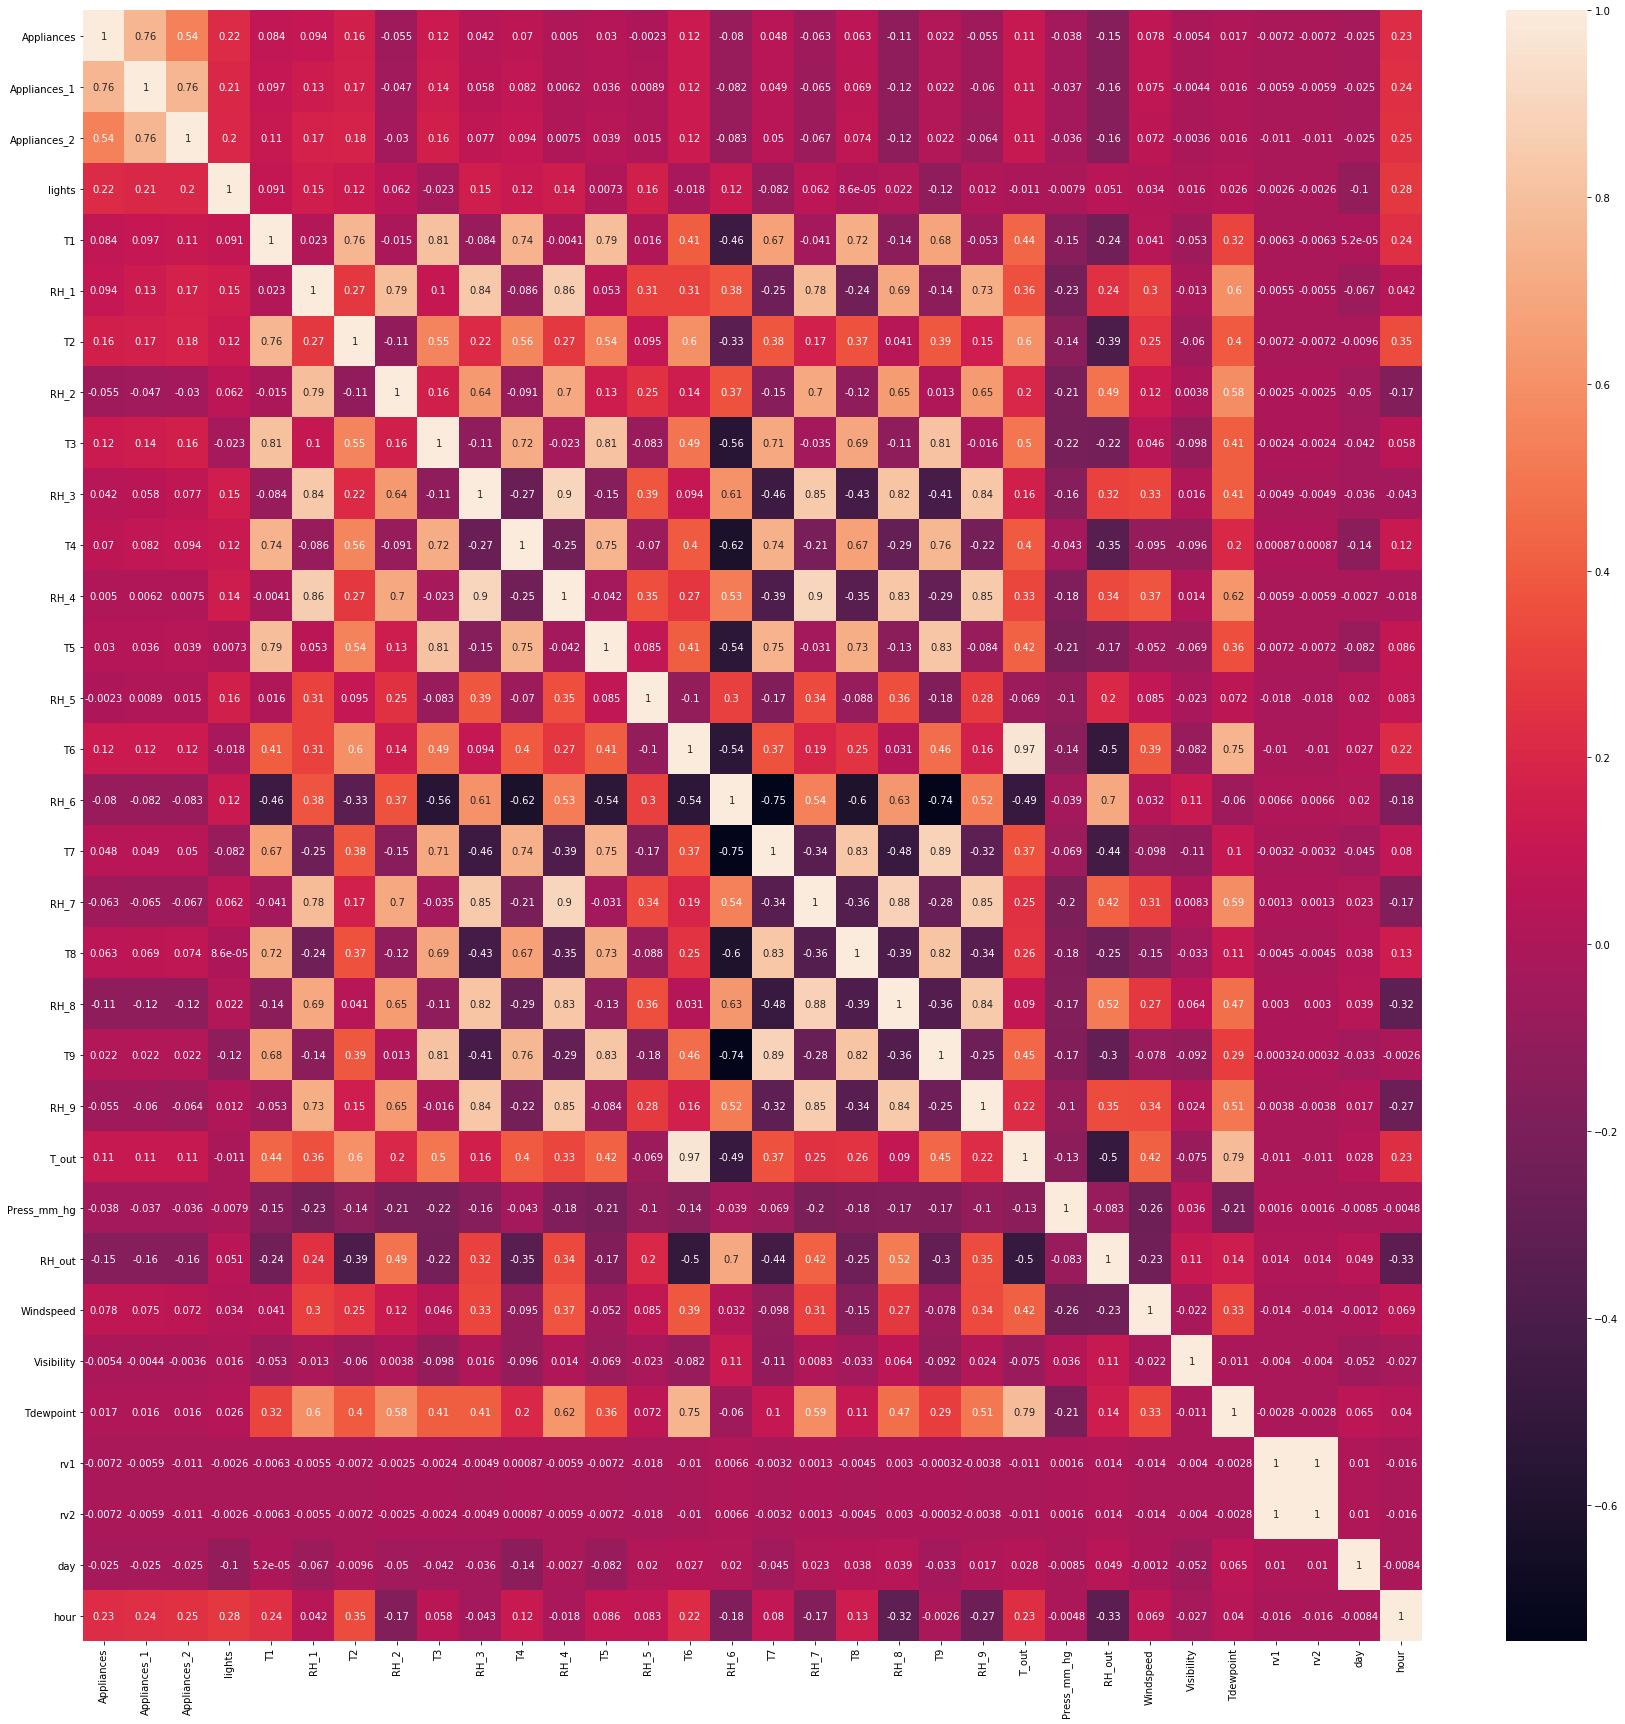

In [7]:
corrMap = master_df[:train_records][target + features].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corrMap, annot = True)

### Define Parameters to Perform Grid Search using Time Series Cross Validation

In [8]:
params = {"gamma": [0.1, 1, 10],
          "kernel": ["linear", "rbf"],
          "C": [0.01, 1, 10]
          }
params

{'gamma': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'C': [0.01, 1, 10]}

In [9]:
# Make cv scorer
score = make_scorer(r2_score, greater_is_better=True)

# Create an object to perform time series cross validation
tscv  = TimeSeriesSplit(n_splits=2)
# Define Model
model = SVR()
# Perform Grid Search
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=params, scoring = score, n_jobs = 1, verbose = 2)

optimal_model = gsearch.fit(X_train, y_train.Appliances.ravel())

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] C=0.01, gamma=0.1, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.01, gamma=0.1, kernel=linear, total=   9.1s
[CV] C=0.01, gamma=0.1, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ................. C=0.01, gamma=0.1, kernel=linear, total=  31.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total=  12.0s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total=  32.1s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ................... C=0.01, gamma=1, kernel=linear, total=  10.2s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ................... C=0.01, gamma=1, kernel=linear, total=  29.0s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=  12.7s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=  41.3s
[CV] C=0.01, gamma=10, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 75.0min finished


In [15]:
# Optimal model
optimal_model.best_estimator_

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [10]:
# Predict the performance in the test set
preds = optimal_model.predict(X_test)

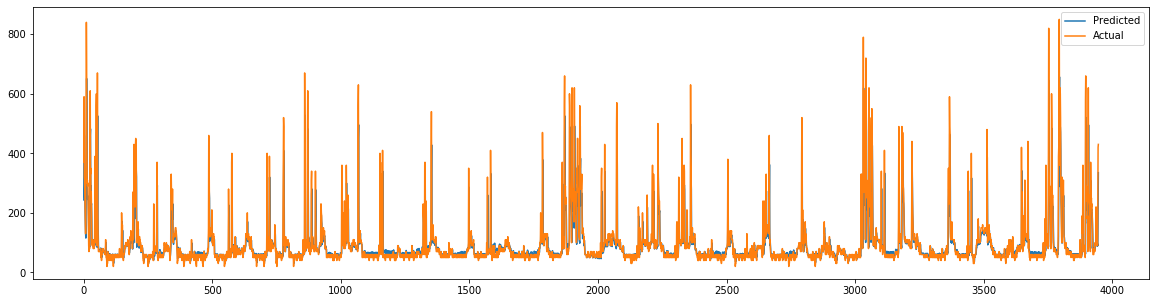

In [21]:
pd.DataFrame({"Predicted":preds,"Actual":y_test.values.flatten()}).plot(figsize=(20,5))

In [12]:
r2_score(preds, y_test.values.flatten())

0.2061042700076181

In [13]:
mean_absolute_error(preds, y_test.values.flatten())

25.519391860012416